### Mini-projeto LSTMs

Grupo:
Caio Possidio,
Felipe Neiva
,
Frederick Almeida
,
Ian Braga
,
Rubens Lima

In [81]:
# pre processamento de dados
import pandas as pd
import numpy as np

# deep learning framework
import torch
from torch import nn, optim
import torch.nn.functional as F

# scalers e métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# plotting e visualização
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [82]:
# utilizar cuda para acelerar o treinamento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Carregando o dataset

In [83]:
df = pd.read_csv('btc.csv', index_col='Date', parse_dates=True)
df.head()

,Symbol,Open,High,Low,Close,Volume From,Volume To
Date,,,,,,,
2018-05-26,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
2018-05-25,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2018-05-24,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
2018-05-23,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
2018-05-22,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [84]:
# removendo a coluna symbol
df.drop(columns=['Symbol'], inplace=True)
df.sort_values(by='Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume From,Volume To
Date,,,,,,
2014-12-01,300.0,370.0,300.00,370.0,0.05656,19.53
2014-12-02,370.0,378.0,370.00,378.0,15.01000,5675.07
2014-12-03,378.0,378.0,377.01,378.0,0.54660,206.52
2014-12-04,378.0,378.0,377.10,377.1,0.01000,3.77
2014-12-05,377.1,377.1,377.10,377.1,0.00000,0.00


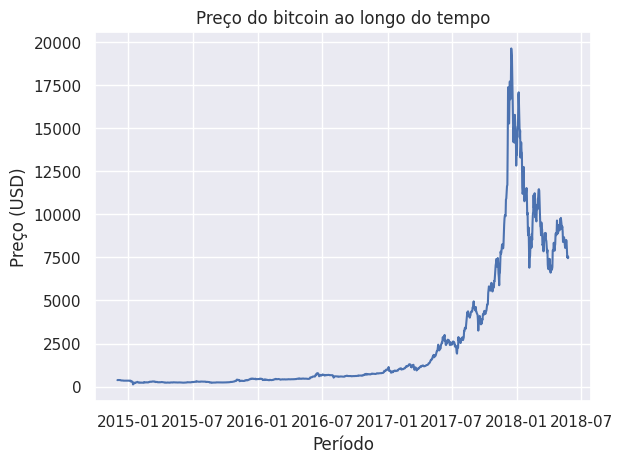

In [85]:
plt.plot(df.Close)
plt.xlabel("Período")
plt.ylabel("Preço (USD)")
plt.title("Preço do bitcoin ao longo do tempo")
plt.show()

In [86]:
# separando features e labels
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((1273, 5), (1273,))

In [87]:
# normalizando os dados
mm = MinMaxScaler()
ss = StandardScaler()

X_scaled = ss.fit_transform(X)
y_scaled = mm.fit_transform(y.reshape(-1, 1))

In [88]:
# define a quantidade de dias que vamos usar para fazer a previsão (n_steps_in) e a quantidade de dias que serão previstos (n_steps_out)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(input_sequences)):
        # encontra o final das sequências de input e output
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(input_sequences): break
        # coleta input_sequence e output_sequence
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

# utilizando 100 dias por instancia p treinar, prevendo 50 dias
X_ss, y_mm = split_sequences(X_scaled, y_scaled, 100, 50)
print(X_ss.shape, y_mm.shape)

(1125, 100, 5) (1125, 50)


In [89]:
X_ss[0]

array([[-0.58087524, -0.56218474, -0.58526647, -1.03228266, -0.42210713],
       [-0.56238099, -0.56016332, -0.5655982 , -1.0307777 , -0.42205355],
       [-0.56026736, -0.56016332, -0.56362856, -1.03223334, -0.42210536],
       [-0.56026736, -0.56016332, -0.56360328, -1.03228734, -0.42210728],
       [-0.56050514, -0.56039073, -0.56360328, -1.03228835, -0.42210732],
       [-0.56050514, -0.56016332, -0.56360328, -1.03228684, -0.42210727],
       [-0.56026736, -0.56016332, -0.5633504 , -1.03228835, -0.42210732],
       [-0.56026736, -0.56016332, -0.56419333, -1.0322647 , -0.42210648],
       [-0.56105997, -0.56092136, -0.56419333, -1.03228835, -0.42210732],
       [-0.56105997, -0.55510977, -0.56826747, -1.03228634, -0.42210725],
       [-0.56489092, -0.56458518, -0.56826747, -1.03228835, -0.42210732],
       [-0.56489092, -0.55991065, -0.57121771, -1.03197133, -0.42209675],
       [-0.56766506, -0.5672383 , -0.57121771, -1.03228835, -0.42210732],
       [-0.56766506, -0.5672383 , -0.5

In [90]:
y_mm[0]

array([0.00883564, 0.00904403, 0.00901741, 0.00855095, 0.00841219,
       0.0085745 , 0.0088085 , 0.00854429, 0.00709217, 0.00733641,
       0.00735842, 0.00726216, 0.00768049, 0.00745571, 0.00659549,
       0.00650282, 0.00666462, 0.00658884, 0.0068341 , 0.0063277 ,
       0.00658423, 0.00641372, 0.00651562, 0.00688582, 0.00694726,
       0.00690579, 0.00724322, 0.00704403, 0.00694675, 0.0064849 ,
       0.00633129, 0.00593241, 0.00604864, 0.00604352, 0.00604352,
       0.00514747, 0.005319  , 0.00558577, 0.00529954, 0.00532463,
       0.0053277 , 0.00537839, 0.00588377, 0.00583717, 0.00591347,
       0.00575422, 0.00548182, 0.00514593, 0.00548899, 0.00540092])

In [91]:
y_scaled[99:149].squeeze(1)

array([0.00883564, 0.00904403, 0.00901741, 0.00855095, 0.00841219,
       0.0085745 , 0.0088085 , 0.00854429, 0.00709217, 0.00733641,
       0.00735842, 0.00726216, 0.00768049, 0.00745571, 0.00659549,
       0.00650282, 0.00666462, 0.00658884, 0.0068341 , 0.0063277 ,
       0.00658423, 0.00641372, 0.00651562, 0.00688582, 0.00694726,
       0.00690579, 0.00724322, 0.00704403, 0.00694675, 0.0064849 ,
       0.00633129, 0.00593241, 0.00604864, 0.00604352, 0.00604352,
       0.00514747, 0.005319  , 0.00558577, 0.00529954, 0.00532463,
       0.0053277 , 0.00537839, 0.00588377, 0.00583717, 0.00591347,
       0.00575422, 0.00548182, 0.00514593, 0.00548899, 0.00540092])

In [92]:
# dividir a quantidade de dados de treino e de teste
def divisao_treino(percent_train):
    train_size = int(len(X_scaled)*percent_train)
    test_size = len(X_scaled) - train_size
    X_train = X_ss[:-(test_size)]
    X_test = X_ss[-(test_size):]

    y_train = y_mm[:-(test_size)]
    y_test = y_mm[-(test_size):]
    return X_train, X_test, y_train, y_test, train_size, test_size


In [93]:
# testando com 80% treino e 20% teste
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.80)

In [94]:
# cria os tensores para o pytorch usar, a partir dos dados
def preprocessing(X_train, X_test, y_train, y_test):
    X_train_tensors = torch.Tensor(X_train)
    X_test_tensors = torch.Tensor(X_test)

    y_train_tensors = torch.Tensor(y_train)
    y_test_tensors = torch.Tensor(y_test)
    X_train_tensors.requires_grad = True
    X_test_tensors.requires_grad = True

    y_train_tensors.requires_grad = True
    y_test_tensors.requires_grad = True

    X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 100,
                                       X_train_tensors.shape[2]))
    X_test_tensors_final = torch.reshape(X_test_tensors,
                                        (X_test_tensors.shape[0], 100,
                                        X_test_tensors.shape[2]))
    return X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors


X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [95]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]


X.iloc[-149:-145]

,Open,High,Low,Volume From,Volume To
Date,,,,,
2017-12-29,14450.01,15105.34,14041.81,17235.04,251682459.9
2017-12-30,14565.05,14639.79,12500.00,25286.65,340875743.9
2017-12-31,12839.99,14280.26,12633.80,17428.57,234823165.7
2018-01-01,13863.13,13889.00,12952.50,11484.01,154169331.5


In [96]:
y_check[-1]

array([6894.01, 7020.01, 6771.13, 6824.99, 6942.99, 7916.  , 7893.19,
       8003.11, 8355.25, 8048.93, 7892.1 , 8152.05, 8274.  , 8866.27,
       8915.42, 8795.01, 8931.3 , 9648.  , 8865.98, 9272.11, 8922.55,
       9329.99, 9389.01, 9243.83, 9072.29, 9190.48, 9725.74, 9685.  ,
       9800.  , 9600.  , 9353.  , 9177.81, 9300.08, 9010.51, 8403.33,
       8475.  , 8686.1 , 8670.  , 8477.46, 8344.  , 8059.  , 8238.51,
       8235.6 , 8516.86, 8393.44, 7987.7 , 7505.  , 7584.15, 7459.11,
       7520.  ])

In [97]:
df.Close.values[-50:]

array([6894.01, 7020.01, 6771.13, 6824.99, 6942.99, 7916.  , 7893.19,
       8003.11, 8355.25, 8048.93, 7892.1 , 8152.05, 8274.  , 8866.27,
       8915.42, 8795.01, 8931.3 , 9648.  , 8865.98, 9272.11, 8922.55,
       9329.99, 9389.01, 9243.83, 9072.29, 9190.48, 9725.74, 9685.  ,
       9800.  , 9600.  , 9353.  , 9177.81, 9300.08, 9010.51, 8403.33,
       8475.  , 8686.1 , 8670.  , 8477.46, 8344.  , 8059.  , 8238.51,
       8235.6 , 8516.86, 8393.44, 7987.7 , 7505.  , 7584.15, 7459.11,
       7520.  ])

In [98]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super().__init__()
        self.num_classes = num_classes # tamanho da saída
        self.num_layers = num_layers # número de camadas
        self.input_size = input_size # tamanho da entrada
        self.hidden_size = hidden_size # neuronios em cada camada
        # LSTM
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout_rate) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # totalmente conectado
        self.fc_2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        # cell state
        c_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        # propaga a entrada no LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn[-1]
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [99]:
def training_loop(
    n_epochs, lstm,
    optimiser, loss_fn,
    X_train, y_train,
    X_test, y_test, device
    ):

    lstm.to(device)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        with torch.no_grad():
            test_preds = lstm(X_test)
            test_loss = loss_fn(test_preds, y_test)

        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (
                epoch,
                loss.item(),
                test_loss.item()
            )
        )

## Teste inicial com nossa `LSTM`

```python
# Aqui utilizaremos uma arquitetura simples e uma escolha de hiperparâmetros mais básica, entre esses hiperparâmetros temos:
```

- `épocas`: 1000
- `learning rate`: 0.001
- `hidden size`: 10
- `layers`: 3

In [100]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 5 # number of features
hidden_size = 10 # number of features in hidden state
num_layers = 3 # number of stacked lstm layers

num_classes = 50 # number of output classes

lstm = LSTM(
    num_classes,
    input_size,
    hidden_size,
    num_layers,
    0.2
)

In [101]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [102]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)



Epoch: 0, train loss: 0.01096, test loss: 0.23342
Epoch: 100, train loss: 0.00071, test loss: 0.14033
Epoch: 200, train loss: 0.00014, test loss: 0.13374
Epoch: 300, train loss: 0.00010, test loss: 0.11980
Epoch: 400, train loss: 0.00007, test loss: 0.10566
Epoch: 500, train loss: 0.00006, test loss: 0.10495
Epoch: 600, train loss: 0.00005, test loss: 0.10464
Epoch: 700, train loss: 0.00004, test loss: 0.10570
Epoch: 800, train loss: 0.00004, test loss: 0.10531
Epoch: 900, train loss: 0.00003, test loss: 0.10477


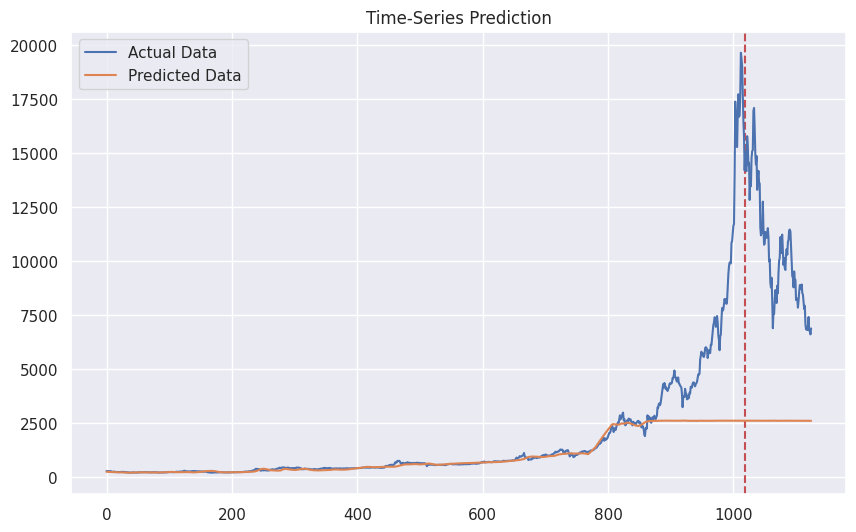

In [103]:
def plot_predictions(lstm, device):
    # Ensure your preprocessing tools like `ss` and `mm` are defined or passed to the function
    df_X_ss = ss.transform(df.drop(columns=['Close']))  # old transformers
    df_y_mm = mm.transform(df.Close.values.reshape(-1, 1))  # old transformers
    # split the sequence
    df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
    # converting to tensors
    df_X_ss = torch.Tensor(df_X_ss).to(device)
    df_y_mm = torch.Tensor(df_y_mm).to(device)
    # reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

    train_predict = lstm(df_X_ss)  # forward pass
    train_predict = train_predict.cpu()  # Move predictions back to CPU for numpy conversion

    data_predict = train_predict.data.numpy()  # numpy conversion
    dataY_plot = df_y_mm.cpu().data.numpy()

    data_predict = mm.inverse_transform(data_predict)  # reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)
    true, preds = [], []
    for i in range(len(dataY_plot)):
        true.append(dataY_plot[i][0])
    for i in range(len(data_predict)):
        preds.append(data_predict[i][0])

    plt.figure(figsize=(10,6))  # plotting
    plt.axvline(x=train_size, c='r', linestyle='--')  # size of the training set

    plt.plot(true, label='Actual Data')  # actual plot
    plt.plot(preds, label='Predicted Data')  # predicted plot
    plt.title('Time-Series Prediction')
    plt.legend()
    plt.savefig("whole_plot.png", dpi=300)
    plt.show()

plot_predictions(lstm, device)

In [104]:
# salvando o modelo
torch.save(lstm.state_dict(), 'model.pth')

## Resultados do Teste `1`

```python
# percebemos um modelo que performou de forma exemplar em seus dados de treino, porém deixou muito a desejar nos dados de teste, portanto podemos visar uma melhoria do modelo ao aplicar estratégias para lidar com o overfit do mesmo.
```

#### `Overfit`

- Aumentar a quantidade de dados
- Diminuir a complexidade
- Early Stopping
- Dropout

---

## Segundo teste para sanar `Overfit`

```python

# Aqui utilizaremos a estratégia de aumentar a quantidade de dados de treinamento do modelo, visando reduzir o overfit, a arquitetura em si será a mesma

In [105]:
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.95)
X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [106]:
def instanciate_lstm(modelo,n_epochs,learning_rate, hidden_size, num_layers, dropout_rate=0.2):
    n_epochs = n_epochs # 1000 epochs
    learning_rate = learning_rate # 0.001 lr

    input_size = 5 # number of features
    hidden_size = hidden_size # number of features in hidden state
    num_layers = num_layers # number of stacked lstm layers

    num_classes = 50 # number of output classes

    modelo = LSTM(
        num_classes,
        input_size,
        hidden_size,
        num_layers,
        dropout_rate
    )

    return modelo, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes

def setup_optimizers(lstm, learning_rate):
    loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
    optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    return loss_fn, optimiser



In [107]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 3)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05409, test loss: 0.18708
Epoch: 100, train loss: 0.00402, test loss: 0.03633
Epoch: 200, train loss: 0.00258, test loss: 0.03860
Epoch: 300, train loss: 0.00139, test loss: 0.04099
Epoch: 400, train loss: 0.00087, test loss: 0.03754
Epoch: 500, train loss: 0.00073, test loss: 0.03669
Epoch: 600, train loss: 0.00065, test loss: 0.04146
Epoch: 700, train loss: 0.00060, test loss: 0.04436
Epoch: 800, train loss: 0.00058, test loss: 0.04329
Epoch: 900, train loss: 0.00051, test loss: 0.04542


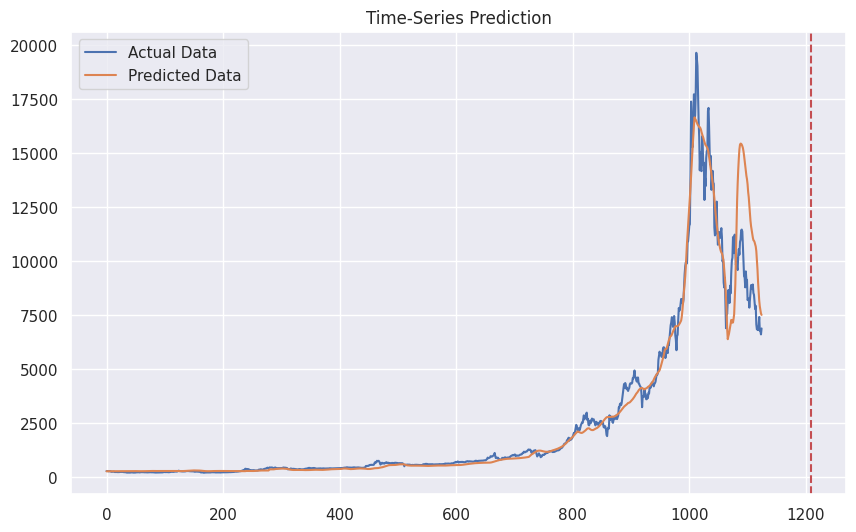

In [108]:
plot_predictions(lstm, device)

---

## Testando a interferência do `num_layers`

```python

# Agora seria interessante ver como é afetado o comportamento do modelo ao alterar o hiperparâmetro de "num_layers"

In [109]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 7)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05131, test loss: 0.18067
Epoch: 100, train loss: 0.01003, test loss: 0.00840
Epoch: 200, train loss: 0.00501, test loss: 0.03967
Epoch: 300, train loss: 0.00334, test loss: 0.04078
Epoch: 400, train loss: 0.00226, test loss: 0.04013
Epoch: 500, train loss: 0.00165, test loss: 0.02583
Epoch: 600, train loss: 0.00107, test loss: 0.00862
Epoch: 700, train loss: 0.00099, test loss: 0.00849
Epoch: 800, train loss: 0.00083, test loss: 0.00839
Epoch: 900, train loss: 0.00080, test loss: 0.00853


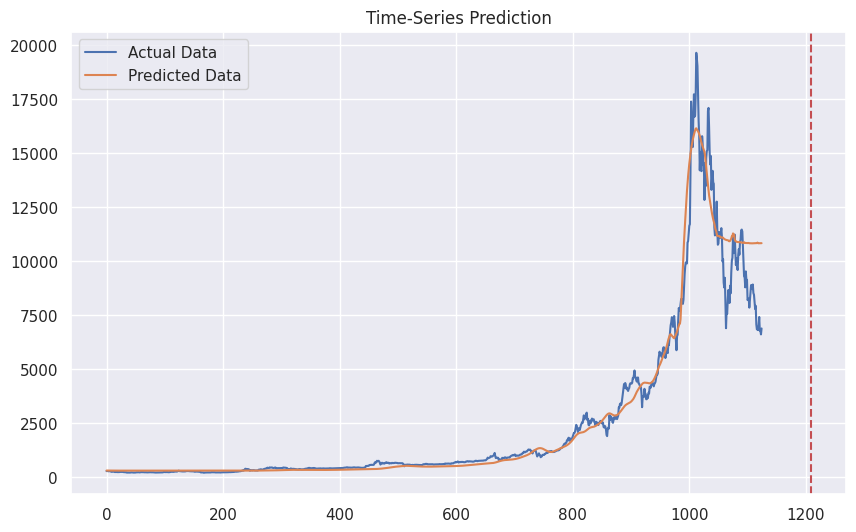

In [110]:
plot_predictions(lstm, device)

## Aumentando ainda mais a quantidade de `num_layers`

```python

In [111]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05848, test loss: 0.20524
Epoch: 100, train loss: 0.00578, test loss: 0.06043
Epoch: 200, train loss: 0.00312, test loss: 0.03909
Epoch: 300, train loss: 0.00155, test loss: 0.01757
Epoch: 400, train loss: 0.00113, test loss: 0.00964
Epoch: 500, train loss: 0.00093, test loss: 0.00834
Epoch: 600, train loss: 0.00078, test loss: 0.00745
Epoch: 700, train loss: 0.00076, test loss: 0.00720
Epoch: 800, train loss: 0.00067, test loss: 0.00737
Epoch: 900, train loss: 0.00063, test loss: 0.00852


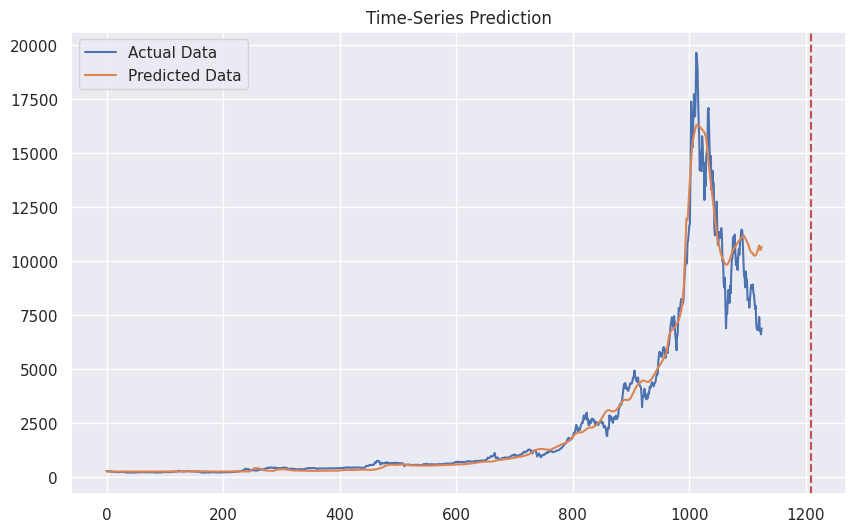

In [112]:
plot_predictions(lstm, device)

In [113]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 10)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05587, test loss: 0.19475
Epoch: 100, train loss: 0.03507, test loss: 0.10841
Epoch: 200, train loss: 0.00733, test loss: 0.02071
Epoch: 300, train loss: 0.00430, test loss: 0.03865
Epoch: 400, train loss: 0.00310, test loss: 0.04168
Epoch: 500, train loss: 0.00292, test loss: 0.03985
Epoch: 600, train loss: 0.00290, test loss: 0.03907
Epoch: 700, train loss: 0.00279, test loss: 0.04059
Epoch: 800, train loss: 0.00261, test loss: 0.03854
Epoch: 900, train loss: 0.00252, test loss: 0.03897


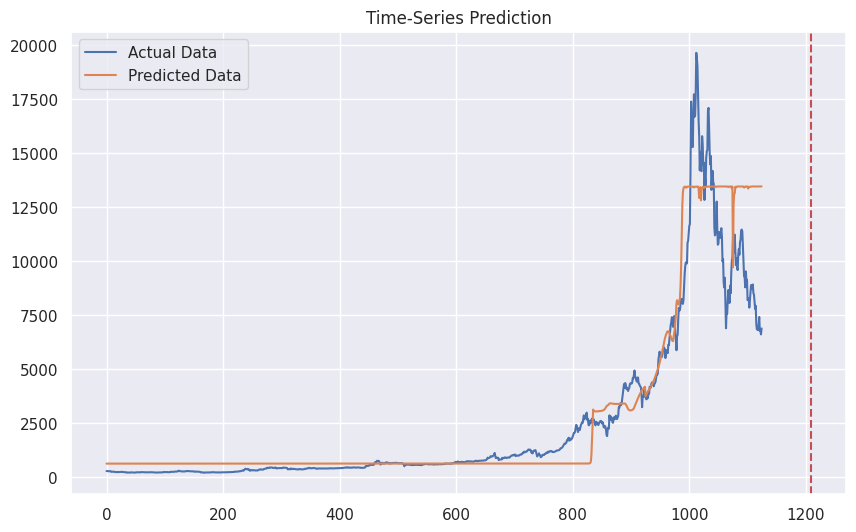

In [114]:
plot_predictions(lstm, device)

Aumentando o dropout

In [115]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 10, 0.4)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05788, test loss: 0.19460
Epoch: 100, train loss: 0.03509, test loss: 0.10852
Epoch: 200, train loss: 0.03509, test loss: 0.10854
Epoch: 300, train loss: 0.03509, test loss: 0.10852
Epoch: 400, train loss: 0.00865, test loss: 0.05521
Epoch: 500, train loss: 0.00716, test loss: 0.03400
Epoch: 600, train loss: 0.00514, test loss: 0.04056
Epoch: 700, train loss: 0.00330, test loss: 0.04365
Epoch: 800, train loss: 0.00308, test loss: 0.04190
Epoch: 900, train loss: 0.00295, test loss: 0.04309


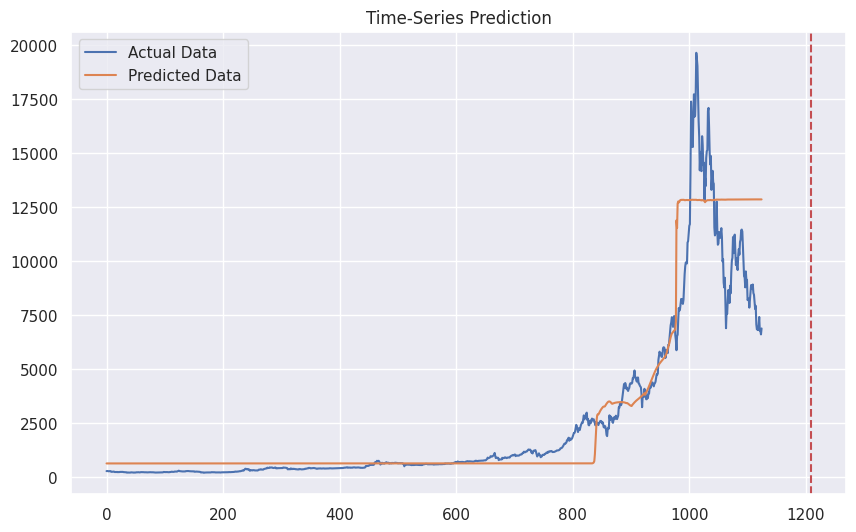

In [116]:
plot_predictions(lstm, device)

### alterando o hidden_size

In [117]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 15, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.05090, test loss: 0.17601
Epoch: 100, train loss: 0.00414, test loss: 0.03825
Epoch: 200, train loss: 0.00170, test loss: 0.01769
Epoch: 300, train loss: 0.00099, test loss: 0.00718
Epoch: 400, train loss: 0.00077, test loss: 0.00802
Epoch: 500, train loss: 0.00070, test loss: 0.00892
Epoch: 600, train loss: 0.00059, test loss: 0.00897
Epoch: 700, train loss: 0.00054, test loss: 0.00853
Epoch: 800, train loss: 0.00052, test loss: 0.00848
Epoch: 900, train loss: 0.00050, test loss: 0.01004


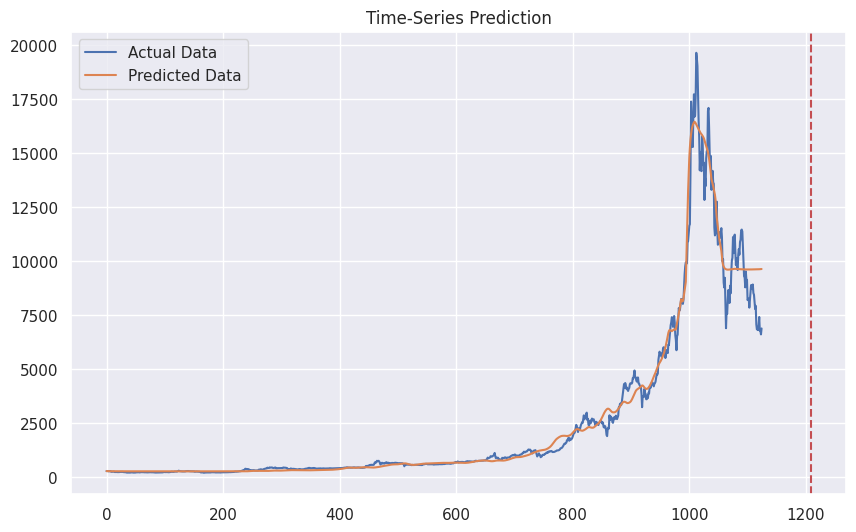

In [118]:
plot_predictions(lstm, device)

In [119]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 20, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.04990, test loss: 0.17878
Epoch: 100, train loss: 0.00427, test loss: 0.04018
Epoch: 200, train loss: 0.00186, test loss: 0.02565
Epoch: 300, train loss: 0.00102, test loss: 0.00986
Epoch: 400, train loss: 0.00079, test loss: 0.00769
Epoch: 500, train loss: 0.00068, test loss: 0.00800
Epoch: 600, train loss: 0.00054, test loss: 0.00737
Epoch: 700, train loss: 0.00050, test loss: 0.00816
Epoch: 800, train loss: 0.00046, test loss: 0.00856
Epoch: 900, train loss: 0.00041, test loss: 0.00846


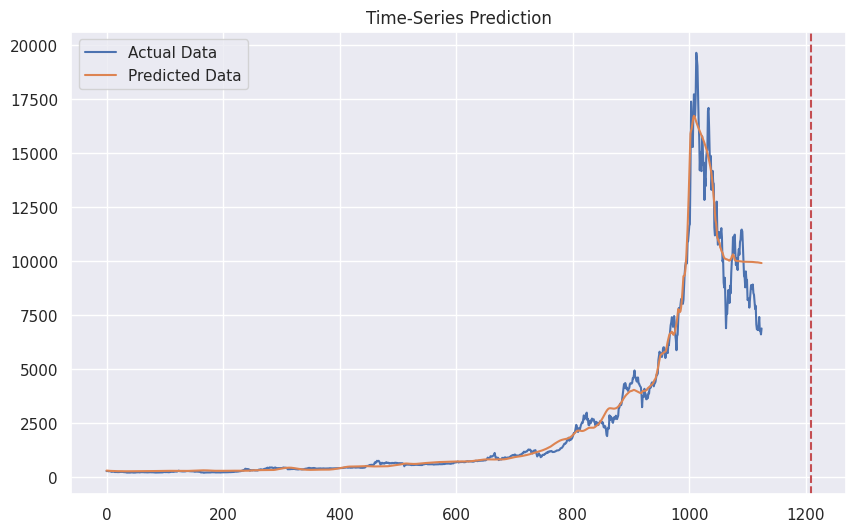

In [120]:
plot_predictions(lstm, device)

### Testando diferentes distribuições dos dados

In [121]:
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.80)
X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [122]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 15, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.00895, test loss: 0.24103
Epoch: 100, train loss: 0.00054, test loss: 0.13411
Epoch: 200, train loss: 0.00012, test loss: 0.12232
Epoch: 300, train loss: 0.00007, test loss: 0.10266
Epoch: 400, train loss: 0.00006, test loss: 0.10356
Epoch: 500, train loss: 0.00004, test loss: 0.10367
Epoch: 600, train loss: 0.00003, test loss: 0.10352
Epoch: 700, train loss: 0.00003, test loss: 0.10236
Epoch: 800, train loss: 0.00003, test loss: 0.10183
Epoch: 900, train loss: 0.00002, test loss: 0.10084


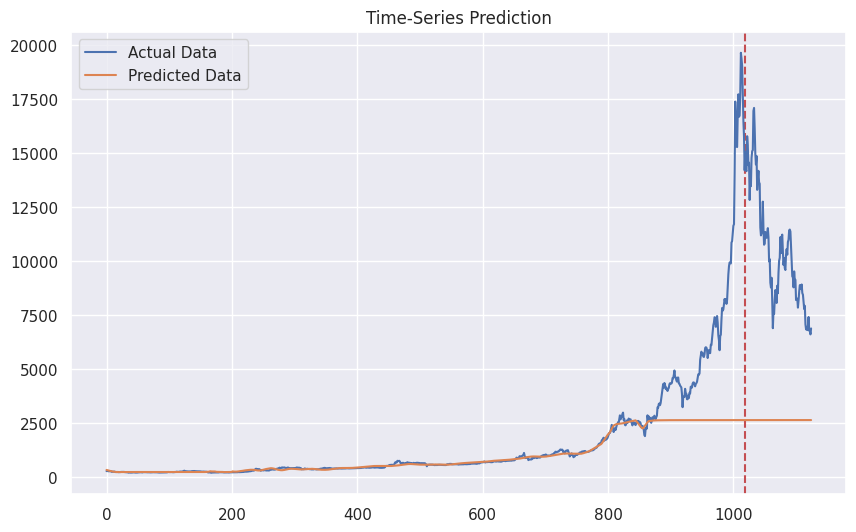

In [123]:
plot_predictions(lstm, device)

In [124]:
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.90)
X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [125]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 15, 5)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors,
              device=device)

Epoch: 0, train loss: 0.03047, test loss: 0.26806
Epoch: 100, train loss: 0.00235, test loss: 0.08712
Epoch: 200, train loss: 0.00091, test loss: 0.09967
Epoch: 300, train loss: 0.00059, test loss: 0.09186
Epoch: 400, train loss: 0.00045, test loss: 0.09293
Epoch: 500, train loss: 0.00035, test loss: 0.09463
Epoch: 600, train loss: 0.00031, test loss: 0.10017
Epoch: 700, train loss: 0.00028, test loss: 0.09968
Epoch: 800, train loss: 0.00027, test loss: 0.10021
Epoch: 900, train loss: 0.00024, test loss: 0.10651


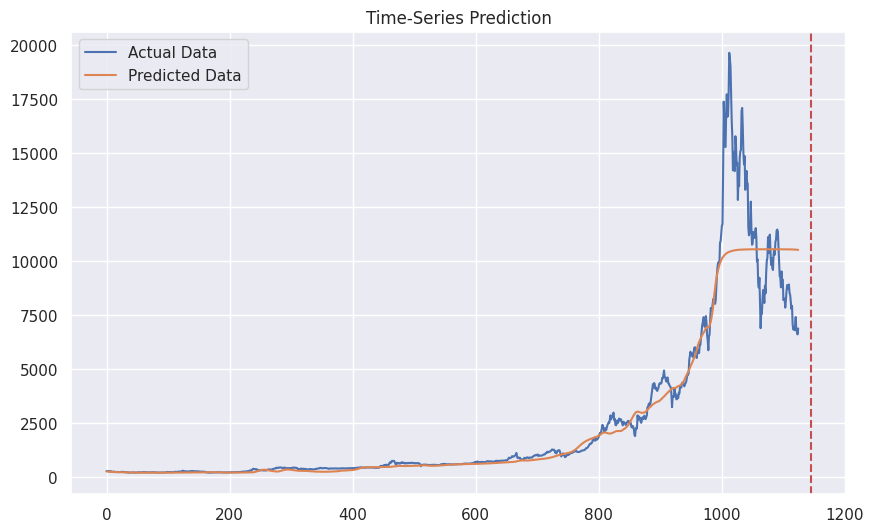

In [126]:
plot_predictions(lstm, device)

## Testes com diferentes tamanhos de Janela

### Alternado a faixa de entrada

In [127]:
def preprocessing(X_train, X_test, y_train, y_test, window_size):
    X_train_tensors = torch.Tensor(X_train)
    X_test_tensors = torch.Tensor(X_test)

    y_train_tensors = torch.Tensor(y_train)
    y_test_tensors = torch.Tensor(y_test)

    X_train_tensors.requires_grad = True
    X_test_tensors.requires_grad = True

    y_train_tensors.requires_grad = True
    y_test_tensors.requires_grad = True

    X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], window_size, X_train_tensors.shape[2]))
    X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], window_size, X_test_tensors.shape[2]))

    return X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors

def evaluate_model(model, X_test, y_test, device):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        loss = torch.nn.MSELoss()(y_pred, y_test)
    return loss.item()

Testing window size: 50
Epoch: 0, train loss: 0.01007, test loss: 0.22787
Epoch: 100, train loss: 0.00029, test loss: 0.13665
Epoch: 200, train loss: 0.00013, test loss: 0.12904
Epoch: 300, train loss: 0.00011, test loss: 0.12925
Testing window size: 75
Epoch: 0, train loss: 0.01167, test loss: 0.25831
Epoch: 100, train loss: 0.00156, test loss: 0.20471
Epoch: 200, train loss: 0.00029, test loss: 0.12882
Epoch: 300, train loss: 0.00008, test loss: 0.11207
Testing window size: 100
Epoch: 0, train loss: 0.00860, test loss: 0.22843
Epoch: 100, train loss: 0.00059, test loss: 0.14632
Epoch: 200, train loss: 0.00017, test loss: 0.12954
Epoch: 300, train loss: 0.00007, test loss: 0.10132
Testing window size: 125
Epoch: 0, train loss: 0.00912, test loss: 0.23576
Epoch: 100, train loss: 0.00031, test loss: 0.13092
Epoch: 200, train loss: 0.00008, test loss: 0.10073
Epoch: 300, train loss: 0.00006, test loss: 0.10296
Testing window size: 150
Epoch: 0, train loss: 0.01134, test loss: 0.24776
Epo

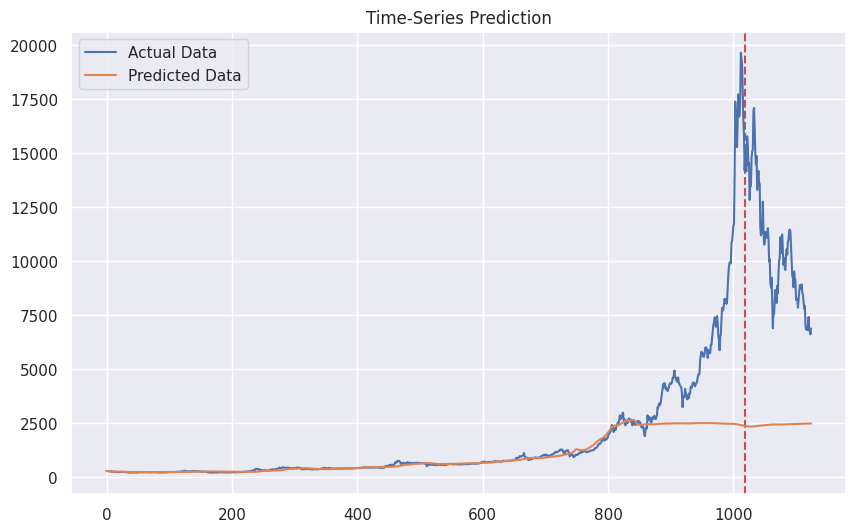


Window size: 75, Performance: 0.10871963202953339


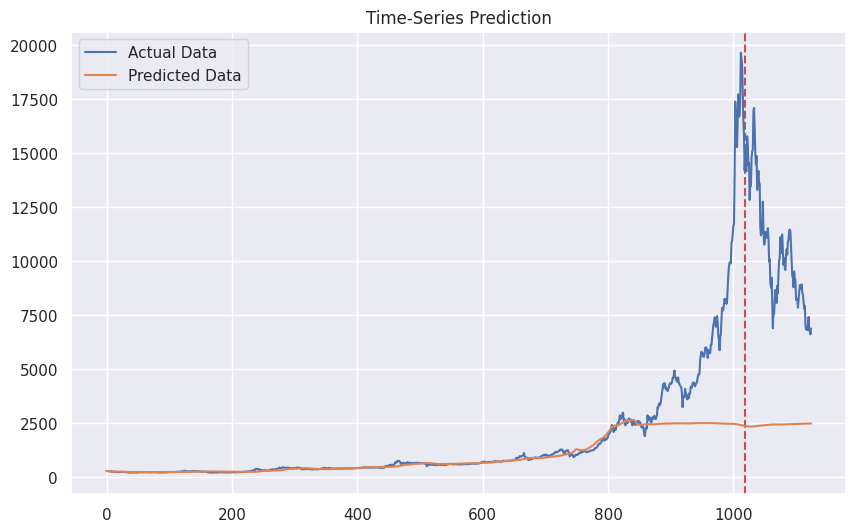


Window size: 100, Performance: 0.10302580147981644


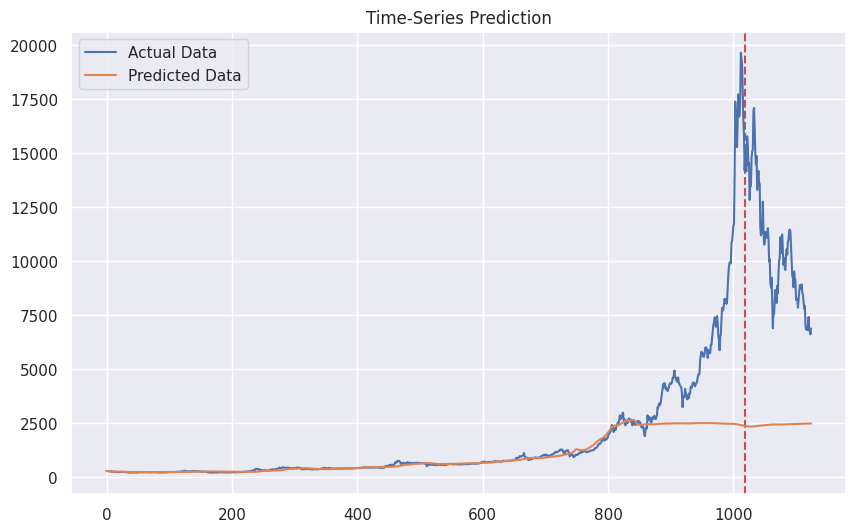


Window size: 125, Performance: 0.1026734933257103


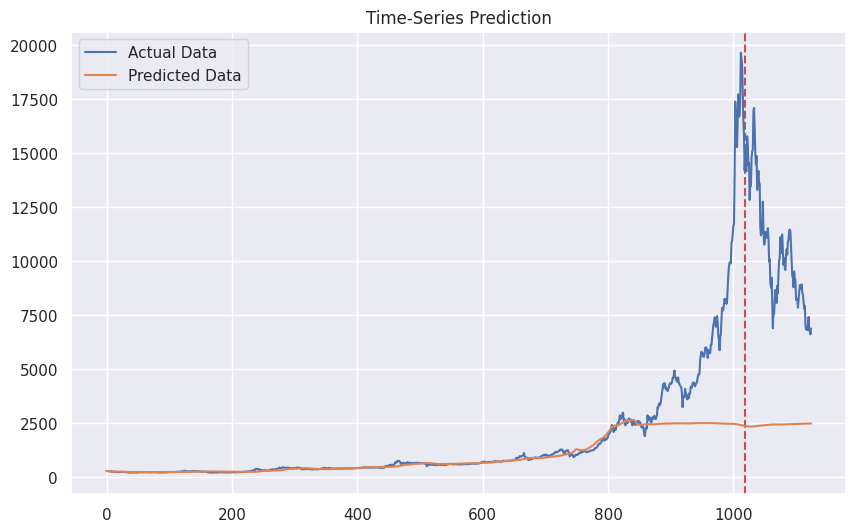


Window size: 150, Performance: 0.10639549791812897


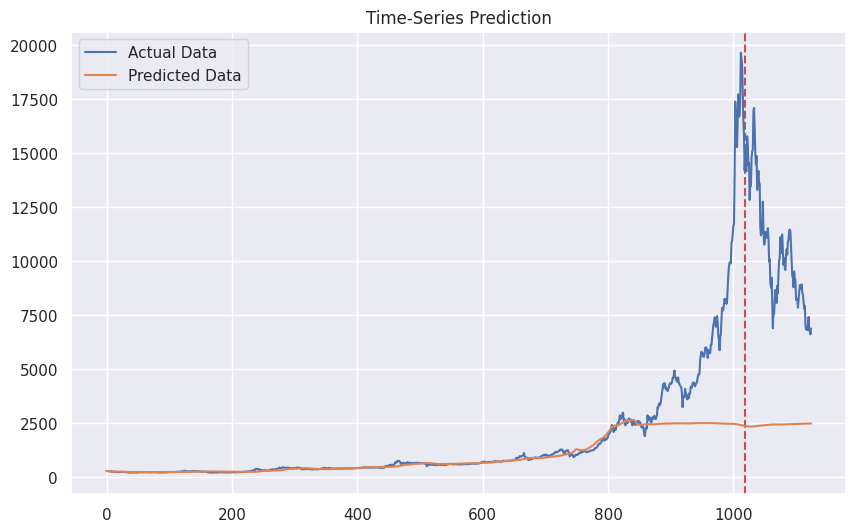

In [129]:
results = []

window_sizes = [50, 75, 100, 125, 150]  # diferentes tamanhos de janela para testar
n_steps_out = 50

for window_size in window_sizes:
    print(f"Testing window size: {window_size}")
    # Preparar os dados com o tamanho de janela atual
    X_ss, y_mm = split_sequences(X_scaled, y_scaled, window_size, n_steps_out)

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test, train_size, test_size = divisao_treino(0.80)
    X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test, window_size)

    # Instanciar e treinar o modelo
    lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 400, 0.001, 15, 5)
    loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

    training_loop(n_epochs=n_epochs,
                  lstm=lstm,
                  optimiser=optimiser,
                  loss_fn=loss_fn,
                  X_train=X_train_tensors_final,
                  y_train=y_train_tensors,
                  X_test=X_test_tensors_final,
                  y_test=y_test_tensors,
                  device=device)

    # Avaliar e armazenar os resultados
    performance = evaluate_model(lstm, X_test_tensors_final, y_test_tensors, device)
    results.append((window_size, performance))

# Imprimir os resultados
for window_size, performance in results:
    print("")
    print(f"Window size: {window_size}, Performance: {performance}")
    plot_predictions(lstm, device)
